In [48]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import math
import os
from math import sqrt
import time
from scipy.integrate import cumtrapz

from rdkit import Chem
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process.kernels import RBF

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import make_scorer

from keras.models import Sequential
from keras.layers import Input, Conv1D, Flatten, Dense, MaxPooling1D, Reshape
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import numpy as np

from tqdm import tqdm

rfecv = 0

restrict = 0
minim = 25
maxim = 300

grid = 1

carbon = 0
#0 = Non-Charged, 1 = Charged, 2 = All
charged = 2

import warnings
warnings.filterwarnings("ignore")

import process_descriptors
import importlib
importlib.reload(process_descriptors)

<module 'process_descriptors' from 'C:\\Users\\nfurth\\-UTORII-\\process_descriptors.py'>

In [49]:
from process_descriptors import process_data, error_plots, count_carbons, charged_frac, NN

Optimal number of features without Early Stopping: 21
Optimal feature names: ['fr_phenol_noOrthoHbond', 'fr_phenol', 'fr_para_hydroxylation', 'fr_oxime', 'chi4v', 'HeavyAtomMolWt', 'FpDensityMorgan3', 'FpDensityMorgan2', 'FpDensityMorgan1', 'NumAromaticRings', 'ExactMolWt', 'lipinskiHBD', 'LabuteASA', 'MaxAbsEStateIndex', 'chi1n', 'EState_VSA6', 'HeavyAtomCount', 'Kappa2', 'NumAtomStereoCenters', 'amw', 'EState_VSA7']


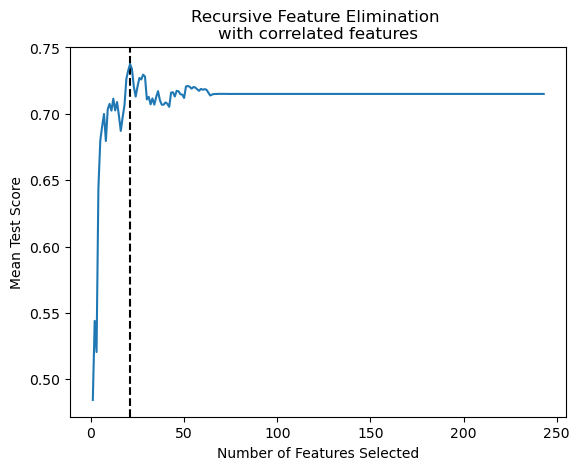

{'gamma': 0, 'max_depth': 7, 'n_estimators': 28, 'reg_lambda': 5}


,Molecule,Target,SMILES
0,1-Bromo-2-methylpropane,-3.3,CC(C)CBr
1,1-Bromo-3-Methylpropane,-3.4,CCCCBr
2,1-Chlorodecane,3.5,CCCCCCCCCCCl
3,1-Chlorododecane,5.6,CCCCCCCCCCCCCl
4,1-Chlorohexadecane,9.8,CCCCCCCCCCCCCCCCCl
...,...,...,...
181,Triolein,21.2,CCCCCCCCC=CCCCCCCCC(=O)OCC(COC(=O)CCCCCCCC=CCC...
182,Tripalmitin,21.2,CCCCCCCCCCCCCCCC(=O)OCC(COC(=O)CCCCCCCCCCCCCCC...
183,Tripalmitolein,19.0,CCCCCCC=CCCCCCCCC(=O)OCC(COC(=O)CCCCCCCC=CCCCC...
184,Tristearin,23.9,CCCCCCCCCCCCCCCCCC(=O)OCC(COC(=O)CCCCCCCCCCCCC...


In [50]:
df, x_train, y_train, x_test, y_test, train_names, test_names, scal = process_data(rfecv, restrict, minim, maxim, grid, carbon, charged, "C:/Users/nfurth/Desktop/Data/EACN/Unoptimized/targets.csv")
df

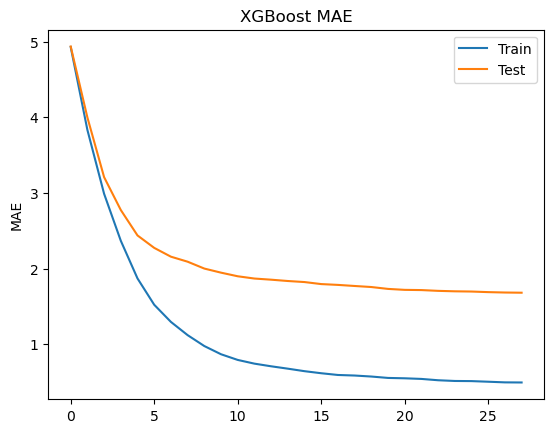

Training Metrics:
Training R2: 0.975945292267879
Training MAE: 0.49216702744887436
Training RMSE: 1.042973808802405

Testing Metrics:
Testing R2: 0.9015434400248982
Testing MAE: 1.6796810882876783
Testing RMSE: 2.2505784988982023


In [45]:
mt = time.time()

eval_set = [(x_train, y_train), (x_test, y_test)]
model = XGBRegressor(gamma=1, reg_lambda = 5, max_depth=7, n_estimators=28, sampling_method = 'uniform',
       n_jobs=-1, verbosity=0, early_stopping = True, eval_metric=["error", "mae"], eval_set=eval_set)
model.fit(x_train, y_train, eval_set=eval_set, verbose=0)

results = model.evals_result()

fig, ax = plt.subplots()

epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()

plt.ylabel('MAE')
plt.title('XGBoost MAE')
plt.show()

y_pred, y_test_pred = model.predict(x_train), model.predict(x_test)

train_rmse, test_rmse = np.sqrt(mean_squared_error(y_train, y_pred)), np.sqrt(mean_squared_error(y_test, y_test_pred))

train_r2, test_r2 = r2_score(y_train, y_pred), r2_score(y_test, y_test_pred)

train_mae, test_mae = mean_absolute_error(y_train, y_pred), mean_absolute_error(y_test, y_test_pred)

print("Training Metrics:")
print(f"Training R2: {train_r2}")
print(f"Training MAE: {train_mae}")
print(f"Training RMSE: {train_rmse}")

print("\nTesting Metrics:")
print(f"Testing R2: {test_r2}")
print(f"Testing MAE: {test_mae}")
print(f"Testing RMSE: {test_rmse}")

CNN = NN(x_train, x_test, y_train, y_test, 32, 1, 1, 100)

x_train = np.array(x_train).reshape(-1, x_train[0].shape[0], 1).astype(np.float32)  
x_test = np.array(x_test).reshape(-1, x_train[0].shape[0], 1).astype(np.float32)    
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

CNN.fit(x_train, y_train, epochs=25, batch_size=32, validation_split=0.3)

y_pred, y_test_pred = CNN.predict(x_train), CNN.predict(x_test)

train_rmse, test_rmse = np.sqrt(mean_squared_error(y_train, y_pred)), np.sqrt(mean_squared_error(y_test, y_test_pred))

train_r2, test_r2 = r2_score(y_train, y_pred), r2_score(y_test, y_test_pred)

train_mae, test_mae = mean_absolute_error(y_train, y_pred), mean_absolute_error(y_test, y_test_pred)

print("Training Metrics:")
print(f"Training R2: {train_r2}")
print(f"Training MAE: {train_mae}")
print(f"Training RMSE: {train_rmse}")

print("\nTesting Metrics:")
print(f"Testing R2: {test_r2}")
print(f"Testing MAE: {test_mae}")
print(f"Testing RMSE: {test_rmse}")

In [46]:
descriptor_names = list(Chem.rdMolDescriptors.Properties.GetAvailableProperties())
descriptor_names = descriptor_names + ['BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'EState_VSA1', 'EState_VSA10', 'EState_VSA11', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'ExactMolWt', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'FractionCSP3', 'HallKierAlpha', 'HeavyAtomCount', 'HeavyAtomMolWt', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'MaxAbsEStateIndex', 'MaxAbsPartialCharge', 'MaxEStateIndex', 'MaxPartialCharge', 'MinAbsEStateIndex', 'MinAbsPartialCharge', 'MinEStateIndex', 'MinPartialCharge', 'MolLogP', 'MolMR', 'MolWt', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRadicalElectrons', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'NumValenceElectrons', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'RingCount', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9', 'TPSA', 'VSA_EState1', 'VSA_EState10', 'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState6', 'VSA_EState7', 'VSA_EState8', 'VSA_EState9', 'fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_N', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO', 'fr_C_S', 'fr_HOCCN', 'fr_Imine', 'fr_NH0', 'fr_NH1', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH', 'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_amide', 'fr_amidine', 'fr_aniline', 'fr_aryl_methyl', 'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_benzene', 'fr_benzodiazepine', 'fr_bicyclic', 'fr_diazo', 'fr_dihydropyridine', 'fr_epoxide', 'fr_ester', 'fr_ether', 'fr_furan', 'fr_guanido', 'fr_halogen', 'fr_hdrzine', 'fr_hdrzone', 'fr_imidazole', 'fr_imide', 'fr_isocyan', 'fr_isothiocyan', 'fr_ketone', 'fr_ketone_Topliss', 'fr_lactam', 'fr_lactone', 'fr_methoxy', 'fr_morpholine', 'fr_nitrile', 'fr_nitro', 'fr_nitro_arom', 'fr_nitro_arom_nonortho', 'fr_nitroso', 'fr_oxazole', 'fr_oxime', 'fr_para_hydroxylation', 'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_phos_acid', 'fr_phos_ester', 'fr_piperdine', 'fr_piperzine', 'fr_priamide', 'fr_prisulfonamd', 'fr_pyridine', 'fr_quatN', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene', 'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene', 'fr_unbrch_alkane', 'fr_urea', 'qed']

mol_descriptor_calculator = MolecularDescriptorCalculator(descriptor_names)
mols, desc = [None] * len(df.SMILES), [None] * len(df.SMILES)

feature_names = mol_descriptor_calculator.GetDescriptorNames()

for i in range(len(df.SMILES)):
    mols[i] = Chem.MolFromSmiles(df.SMILES[i])
    desc[i] = list_of_descriptor_vals = list(mol_descriptor_calculator.CalcDescriptors(mols[i]))
    
if carbon == 1:
    for i in range(len(desc)):
        tot = count_carbons(df.SMILES[i])
        print(i, tot)
        desc[i].append(tot)   

In [47]:
def transpose_lists(list1, list2):
    transposed_list = list(zip(list1, list2))
    transposed_list_t = list(zip(*transposed_list))
    return transposed_list_t[0], transposed_list_t[1]

new_column_names = ['Molecule', 'target', 'prediction']

tmp = [train_names, y_train, y_pred]
tmp_test = [test_names, y_test, y_pred_test]

df_train = pd.DataFrame(tmp).T
df_train.columns = new_column_names

df_test = pd.DataFrame(tmp_test).T
df_test.columns = new_column_names

# save the training set to a CSV file
df_train.to_csv(rf"Test_train_outputs.csv", index=False)

# save the test set to a CSV file
df_test.to_csv(rf"Test_test_outputs.csv", index=False)